# Scikit-MAAD toolbox for Python

## How to install Python

If Python is not installed on your computer, an easy way is to install the popular Anaconda environment (https://anaconda.org/). It comes with the popular tools :
   * Spyder : IDE for Python
   * Jupyter : which let you create interactive notebooks.
   and the popular packages such as :
   * numpy, scipy, matplolib, bokeh, pylab, pandas, scikit-leanr, scikit-image...
    
A light version of Anaconda exists, it's called Miniconda (https://conda.io/miniconda.html). You need to install manually all the tools and packages :
* Install Spyder : `conda install -c anaconda spyder=3.2.8`
* Install Scikit-image (this will install of the other usefull packages : numpy, scipy, matplotlib, pylab…): `conda install -c anaconda scikit-image=0.13.1`
* Install Scikit-learn (for machine learning) : `conda install -c anaconda scikit-learn=0.19.1` 
* Install Pandas (for data exploration and tables management) : `conda install -c anaconda pandas=0.19.1`
* Install Jupyter (notebook): `conda install -c conda-forge jupyter`. To run Jupyter in the selected directory, run this command in a terminal (for windows, select the terminal anaconda) : `jupyter notebook --notebook-dir="D://chemin//du//repertoire"`

For Matlab users, there is a Thesaurus Matlab <=> Python : http://mathesaurus.sourceforge.net/matlab-numpy.html (import pylab in your python script with `from pylab import *` in order to use directly the functions in the thesaurus)

__________

## How to install the package scikit-MAAD 

To be done

### aide en ligne pour les packages
Doc général de Python https://docs.python.org/3.5/search.html
- matplotlib : http://matplotlib.org/devel/index.html#developers-guide-index
- scipy: https://scipy.org/scipylib/index.html
- numpy: https://docs.scipy.org/doc/numpy/reference/routines.html
- scikit-image : http://scikit-image.org/docs/dev/index.html

Créer un package
* Instructions du lien pour créer un package et le distribuer : https://packaging.python.org/tutorials/packaging-projects/
* Instructions pour créer une hierarchie correct dans un package : https://docs.python.org/3/tutorial/modules.html#packages
* Super lien https://wiki.labomedia.org/index.php/Cr%C3%A9er_son_propre_package_python
____________

## How to use MAAD

This document describes the purpose of MAAD and how to use it step by step
### 1. Setup the environment 
    - clear all the variables
    - load all the modules
    - change the path
    - close all the figures

In [1]:
print(__doc__)

# Clear all the variables 
from IPython import get_ipython
get_ipython().magic('reset -sf')
 
# =============================================================================
# Load the modules
# =============================================================================

import matplotlib.pyplot as plt
import pandas as pd # for csv
import numpy as np
from math import ceil

# Import MAAD modules   
import sys
sys.path.append('D:\\mes_projets\\2018\\_TOOLBOX\\Python\\scikit-maad') 
import maad

# change the path to the current path where the script is
import os
# Get the current dir of the current file
dir_path = os.path.dirname(os.path.realpath('__file__'))
print ("Current working directory %s" % dir_path)
# Go to the parent directory
parent_dir,_,_=dir_path.rpartition('\\')
os.chdir(parent_dir)
# Check current working directory.
print ("Directory changed successfully %s" % os.getcwd())

# Close all the figures (like in Matlab)
plt.close("all")

Automatically created module for IPython interactive environment
Current working directory d:\mes_projets\2018\_TOOLBOX\Python\scikit-maad\docs
Directory changed successfully d:\mes_projets\2018\_TOOLBOX\Python\scikit-maad


### 2. Load sound and preprocess sound
Load the file that will be processed. If you want to see the audiogram, `display=True`

________________________________________________________________________
loading .\data\S4A03998_20180712_060000.wav...
Sampling frequency: 44100Hz
Select left channel


D:\Applications\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


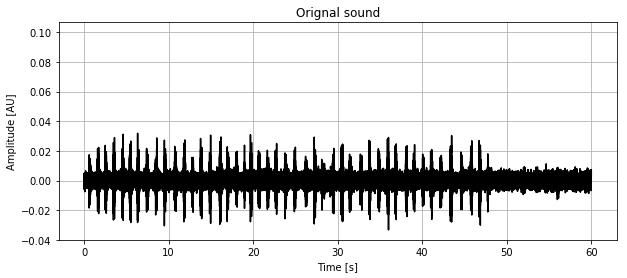

In [2]:
filename=".\\data\\S4A03998_20180712_060000.wav"
savefig_root = filename[0:-4]
s,fs,date = maad.sound.load(filename=filename, channel="left", display=True, savefig=None)

Filter the sound between Low frequency cut (lfc) and High frequency cut (hlc)

________________________________________________________________________
Highpass filter >250Hz in progress...


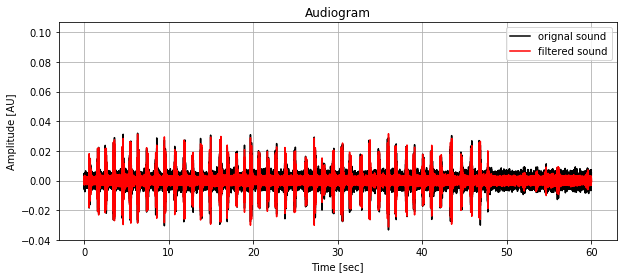

In [3]:
s_filt = maad.sound.select_bandwidth(s, fs, lfc=250, hfc=None, order=2, display=True, savefig=None)

Compute the spectrogram of the sound. The spectrogram function needs the audiogram (s_filt), its sampling frequency (fs), the number of points per segment (nperseg) which is the window length that is used to compute the short fourrier transform. It determines the frequency and time resolution. A large number increases the frequency resolution but inversally decreases the time resolution. 
One can use the function 'convert_dt_df_into_points' in order to convert the time and frequency resolutions into points.
The % of overlapping (overlap) determines the overlapping of each window.

>**Important** : The spectrogram is in db scale by default. If you want a linear scale, sets `db_range=None`

The parameter `db_range` sets the range between -`db_range` to 0dB while `db_gain` adds an offset value). 
--> output = 20*log10(audiogram) + db_gain with values <-db_range =>-db_range and value>0dB => 0dB

________________________________________________________________________
Computing spectrogram with nperseg=2048 and noverlap=1166...
max value in the audiogram 0.00977
Convert in dB scale
Crop the spectrogram along time axis and frequency axis
*************************************************************
   Time resolution dt=0.02s | Frequency resolution df=21.53Hz 
*************************************************************


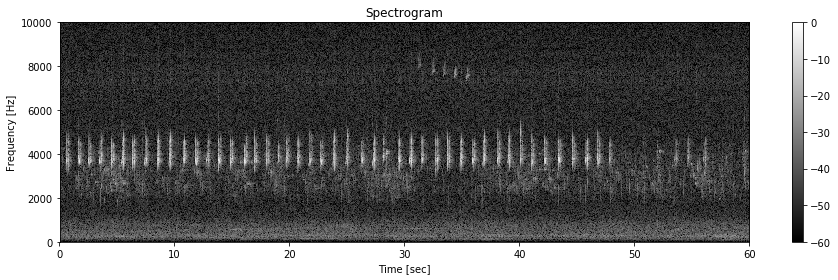


save figure : .\data\S4A03998_20180712_060000_spectrogram.png
Linear rescale between 0 to 1


In [4]:
im_ref,dt,df,ext = maad.sound.spectrogram(s_filt, fs, dt_df_res=[0.02, 20], db_range=60, db_gain=40, rescale=True, 
                                          fcrop =[0,10000], tcrop = [0,60], display=True, savefig=savefig_root)

>**Important** : the spectrogram needs to be rescale between 0 to 1 before image processing


Remove the gaussian noise from the spectrogram. This will remove the gaussian noise and smooth the spectrogram. It is usefull to estimate the background stochastic noise and to extract region of interest (with continuous connexion). The amount of blurring/smoothing is set by the parameter `std`. Correct value should fall between 0 (no smoothing) to 5 (high smoothing).

________________________________________________________________________
Smooth the image with a gaussian filter (std = 1.0)


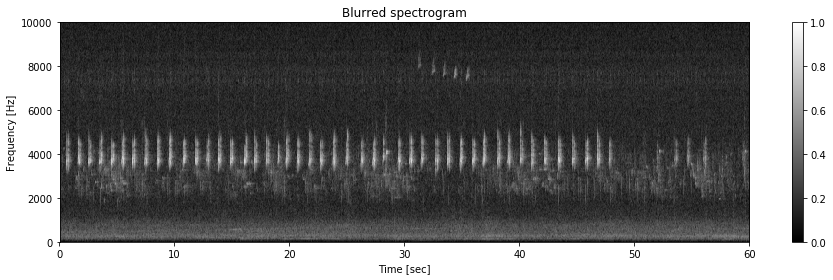

In [5]:
im_smooth_pre = maad.rois.smooth(im_ref, ext, std=1, display=True)

Remove the background noise using spectral subtraction. This method is based on the spectrum of the A posteriori noise profile. It computes an atenuation map in the time-frequency domain. See [1] or [2] for more detail about the algorithm. 

References:

    [1] Steven F. Boll, "Suppression of Acoustic Noise in Speech Using Spectral
    Subtraction", IEEE Transactions on Signal Processing, 27(2),pp 113-120,
    1979

    [2] Y. Ephraim and D. Malah, Speech enhancement using a minimum mean square 
    error short-time spectral amplitude estimator, IEEE. Transactions in
    Acoust., Speech, Signal Process., vol. 32, no. 6, pp. 11091121, Dec. 1984.

Two different groups of parameters need to be set.
- `gauss_win` and `gauss_std` parameters determine the minimum frequency bandwidth in the noise profile. For example, if you set gauss_win to 100 pixels, this means that peak larger than 100 pixels are considered to be the background noise. The lower is the value, the lower details are considered to be noise. gauss_std corresponds to the stantard deviation of the gaussian window width.
- `beta1`, `beta2` and `llambda` parameters determine the spectral subtraction. The higher are the number the more noise is subtracted. Values should be around 1.

________________________________________________________________________
Determine the profile of the stochastic background noise...
Remove the stochastic background noise...


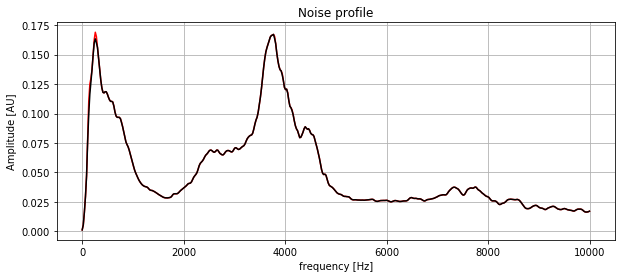

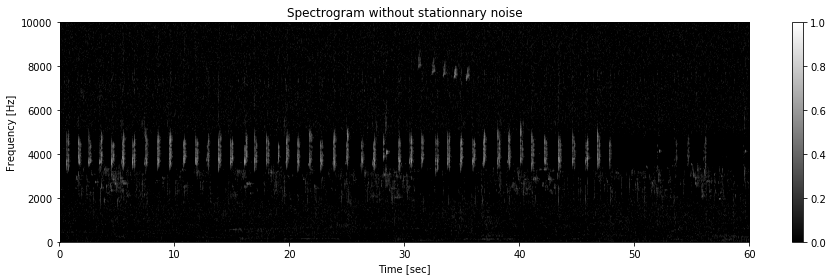

In [6]:
win_px=round(500/df)   # convert window width from Hz into pixels
std_px=round(250/df)    # convert std from im_blurr into pixels
im_denoized = maad.rois.remove_background(im_smooth_pre, ext, gauss_win=win_px, gauss_std=std_px,beta1=0.8, beta2=1, 
                                          llambda=1.1, display=True, savefig=None)

Gaussian filtering could be applied one more time in order to remove the remaining sparse noise and to smooth the image in order to extract more connected regions of interest (ROI)

________________________________________________________________________
Smooth the image with a gaussian filter (std = 3.0)


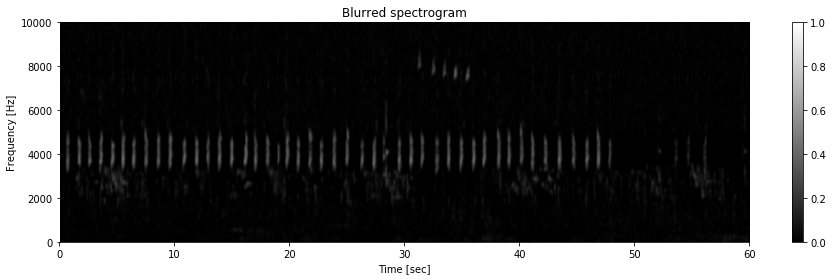

In [7]:
im_smooth_post = maad.rois.smooth(im_denoized, ext, std=3, display=True)

ROIs are extracted from the spectrogram by binarization. This is done by double threshold binarization instead of simple threshold. A first threshold is performed on the data in order to find the seeds, i.e. the pixels that belong to ROIs with a very good confident (this is set by the parameter `bin_std`, this is not an absolute value but rather depends on the standard deviation of the value in the image). Then we keep pixels are connected with values greater than a percentage (`bin_per`) of `bin_std`. This process starts from the seeds.
>***important***: if `mode=absolute`, the parameters are different, with `bin_h` (pixels value > `bin_h` are the seeds) and `bin_l` (pixels value > `bin_l` that are connected to the seeds are keept).

________________________________________________________________________
Double thresholding with values relative to the image...
**********************************************************
  high threshold value 0.10 | low threshold value 0.05
**********************************************************


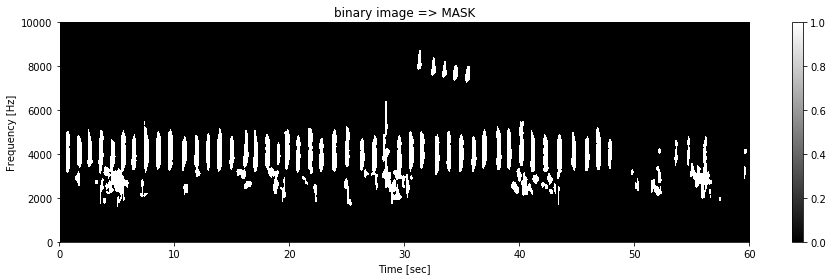

In [8]:
im_bin = maad.rois.create_mask(im_smooth_post, ext, bin_std=7, bin_per=0.5, mode='relative', display=True, savefig=None)

ROIs are extracted from the binary image. 
This can be done **automatically** based on the pixel connection and the area of the ROI. ROIs with areas bigger than `max_roi` or lower than `min_roi` are rejected.

________________________________________________________________________
Automatic ROIs selection in progress...
**********************************************************
  Min ROI area 25 pix² | Max ROI area 137954 pix²
**********************************************************


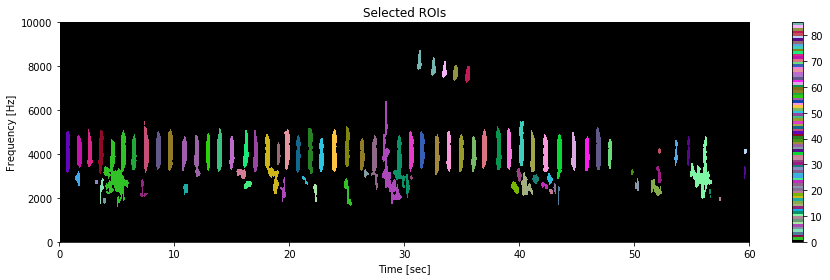

(<matplotlib.axes._subplots.AxesSubplot at 0xd439be0>,
 <Figure size 936x288 with 2 Axes>)

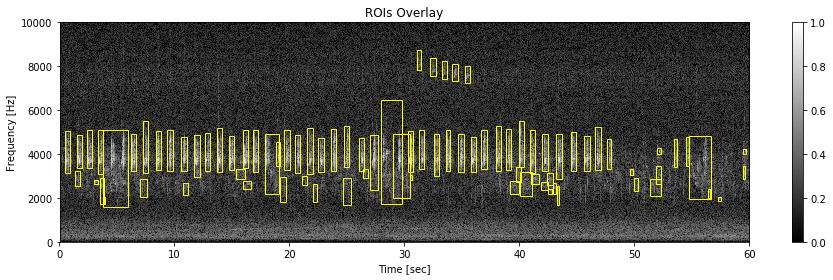

In [9]:
min_f = ceil(100/df) # 100Hz 
min_t = ceil(0.1/dt) # 100ms 
max_f = np.asarray([round(1000/df), im_ref.shape[0]])
max_t = np.asarray([im_ref.shape[1], round(1/dt)])
im_rois, rois_bbox, rois_label = maad.rois.select_rois(im_bin, ext,mode='auto', min_roi=np.min(min_f*min_t), 
                                                       max_roi=np.max(max_f*max_t), display=True,savefig=None)

# display overlay ROIs
maad.rois.overlay_rois(im_ref, ext, rois_bbox, rois_label, savefig=None)

The ROI selection can be done **manually** with an external software (like Audacity : https://www.audacityteam.org/). In this case, the annotation filenam exported by the software is required to construct the bounding box of each ROI. Finally, a AND (boolean operation) can be performed between the rectangular bounding-boxes and binary images obtained automatically in order to select only the relevant part of the ROI defined by its bounding-box.

________________________________________________________________________
Manual ROIs selection in progress...
Annotating filename .\data\S4A03998_20180712_060000_label.txt


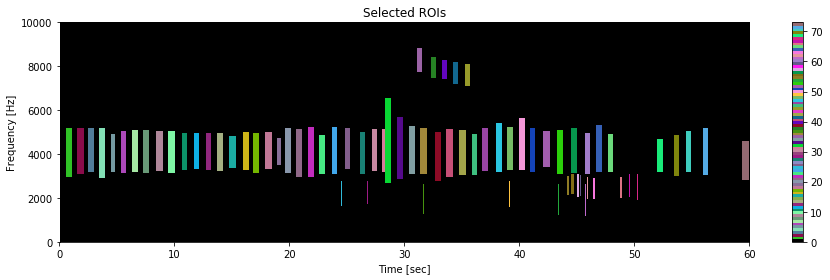

(<matplotlib.axes._subplots.AxesSubplot at 0xd505a58>,
 <Figure size 936x288 with 2 Axes>)

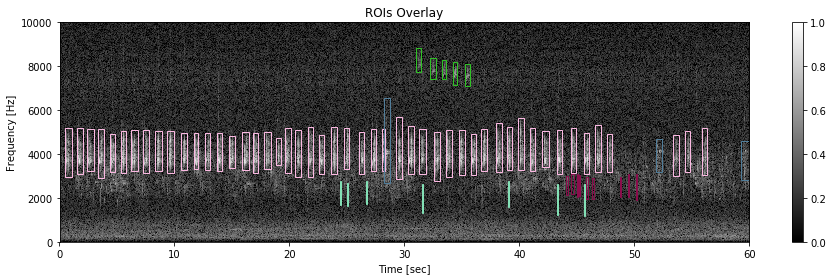

In [10]:
im_rois, rois_bbox, rois_label = maad.rois.select_rois(im_bin,ext,mode_roi='manual', 
                                                       filename='.\data\S4A03998_20180712_060000_label.txt',
                                                       mask=False, display=True, savefig=None)
# display overlay ROIs
maad.rois.overlay_rois(im_ref, ext, rois_bbox, rois_label, savefig=None)

Get features that characterize each ROI.
The features are
- the frequency centroid (i.e. vertical position of the ROI)
- the date centroid (i.e. horizontal position of the ROI, not only in the spectrogram but also on the real time scale (year, month, day, hour, minute and second)
- Shape of the ROI dertermined by wavelet filtering with different kernels (horizontal, vertical and/or with different angles and/or different width) at different pyramid scale. 


<Figure size 432x288 with 0 Axes>

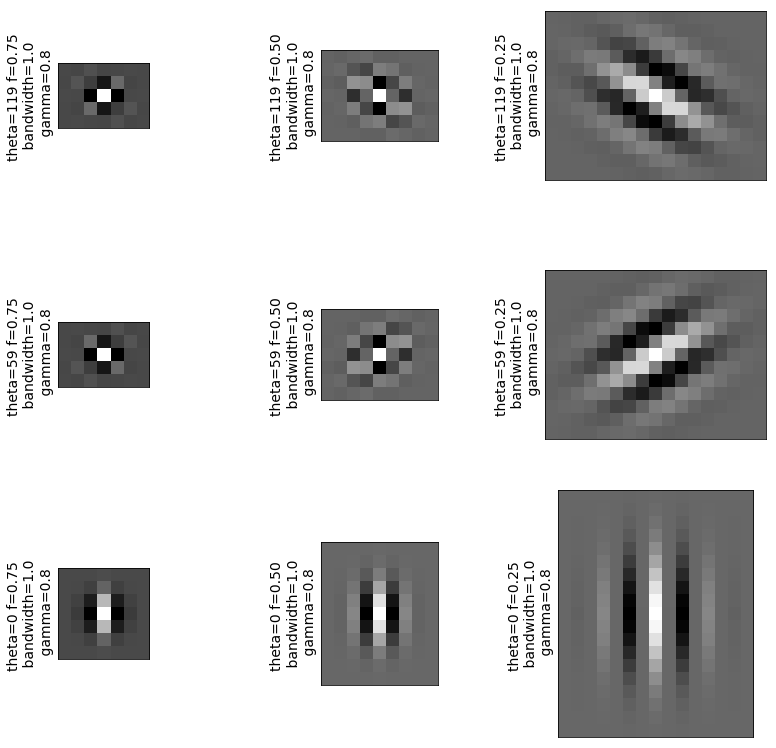

In [11]:
freq = (0.75, 0.5,0.25)
params, kernels = maad.features.filter_bank_2d_nodc(frequency=freq,ntheta=3,bandwidth=1,gamma=0.75,display=True,savefig=None)

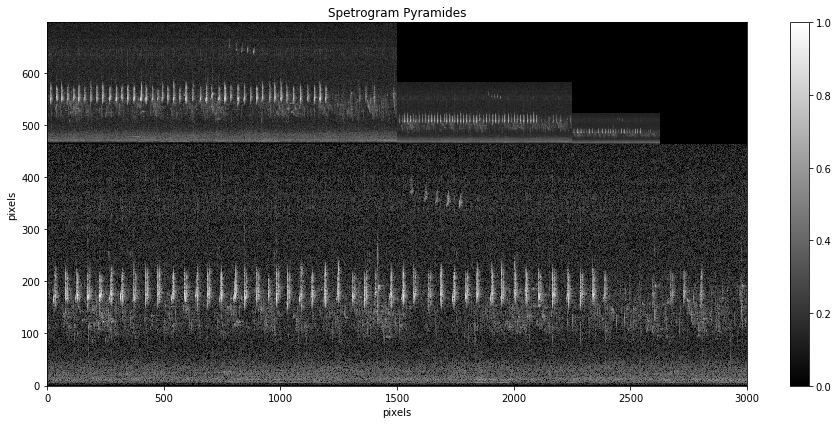

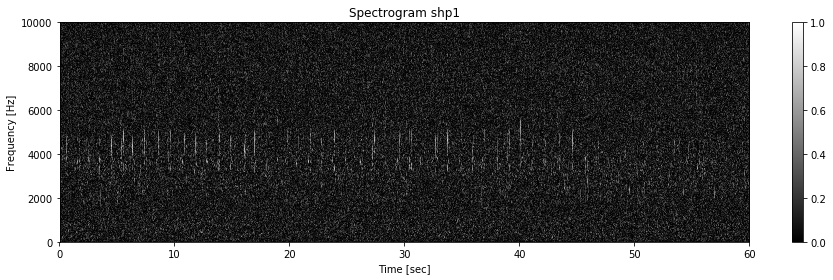

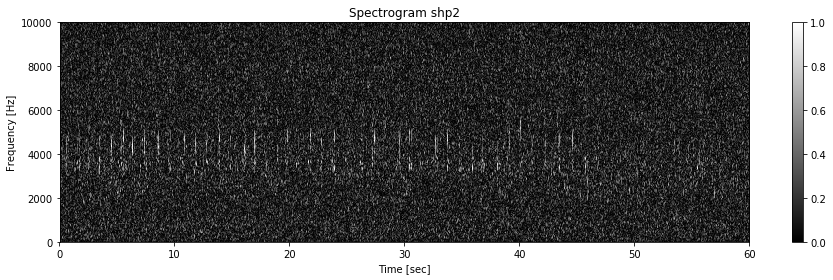

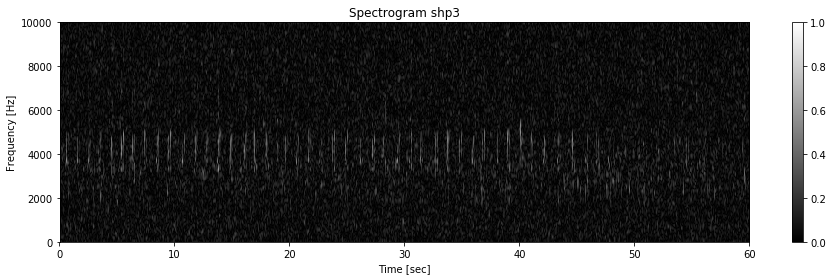

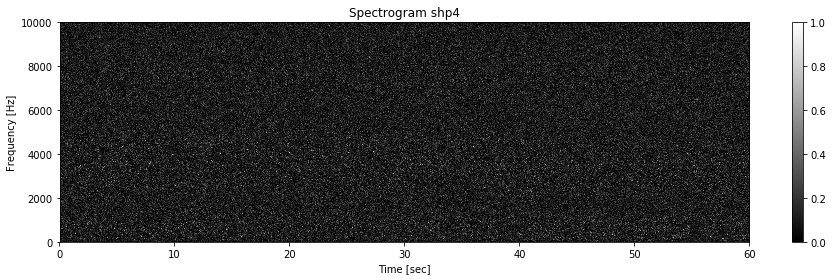

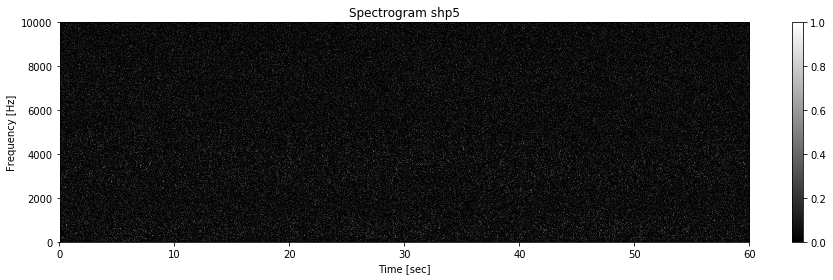

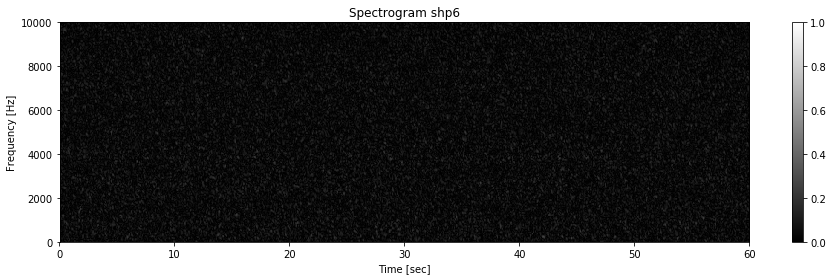

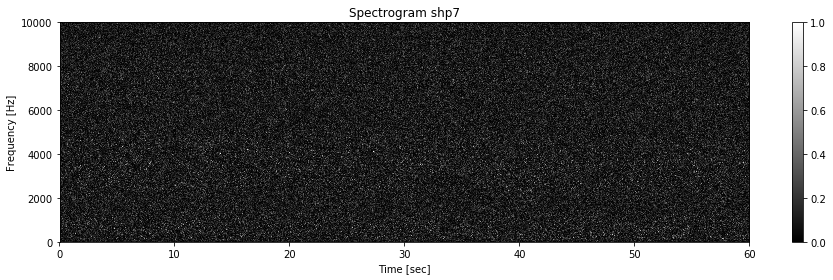

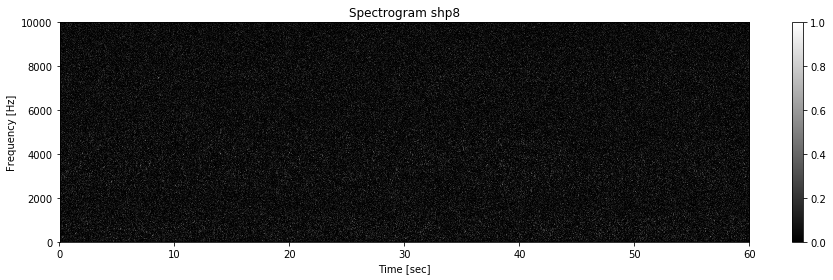

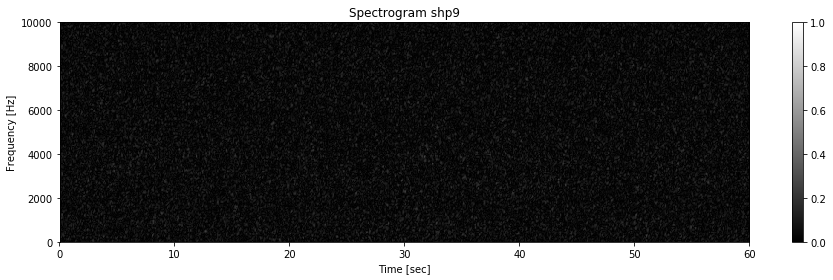

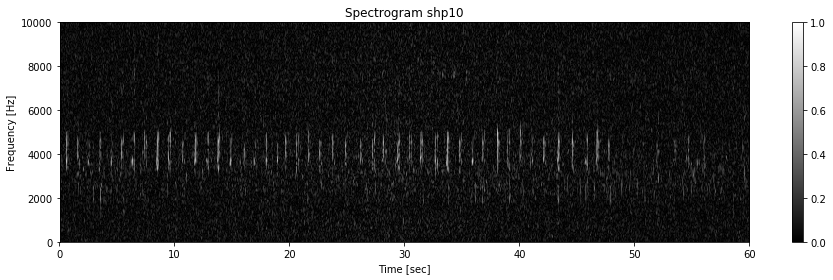

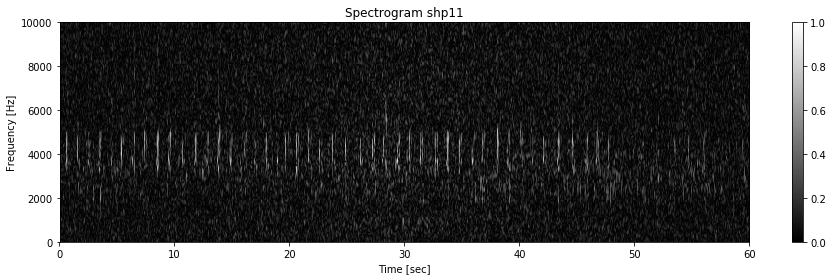

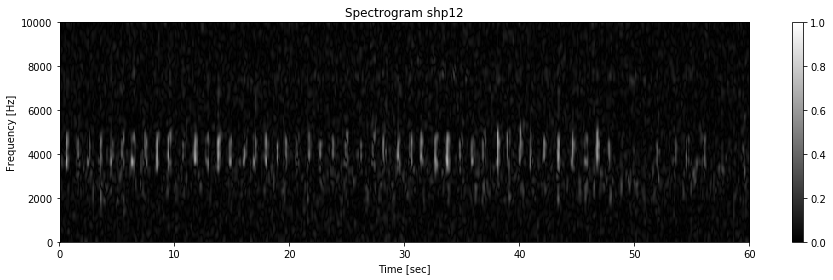

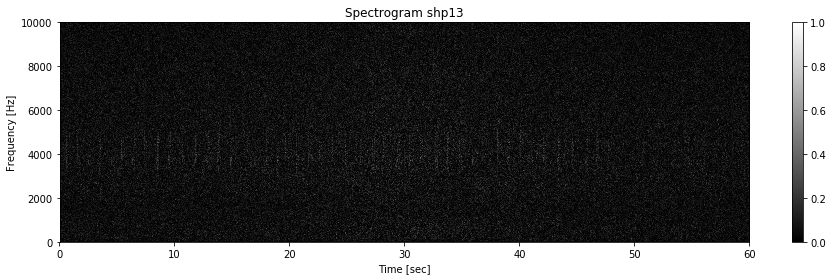

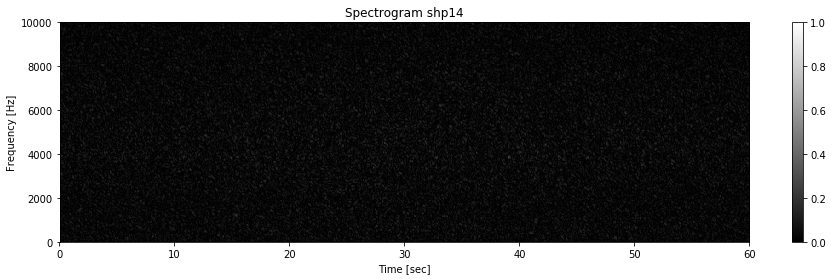

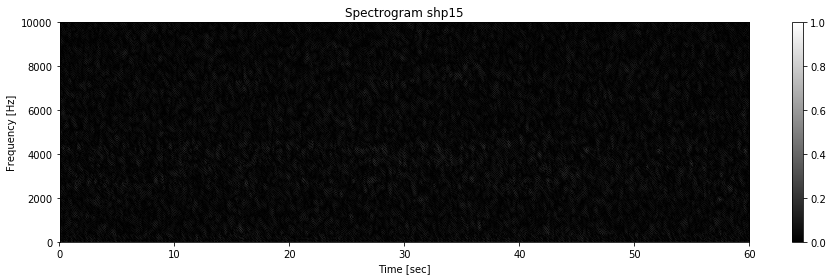

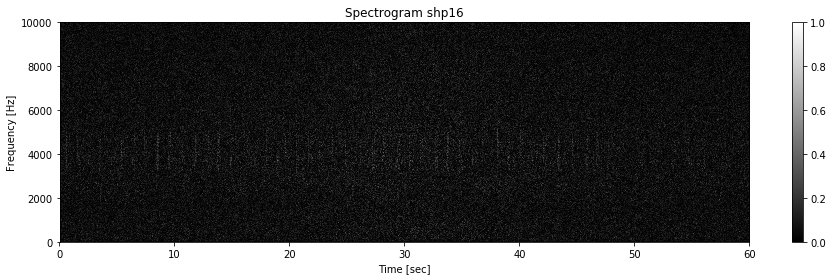

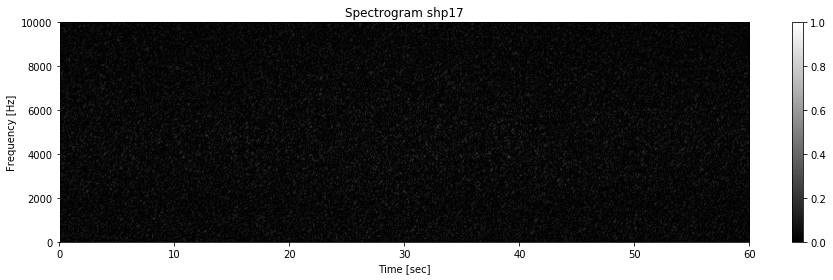

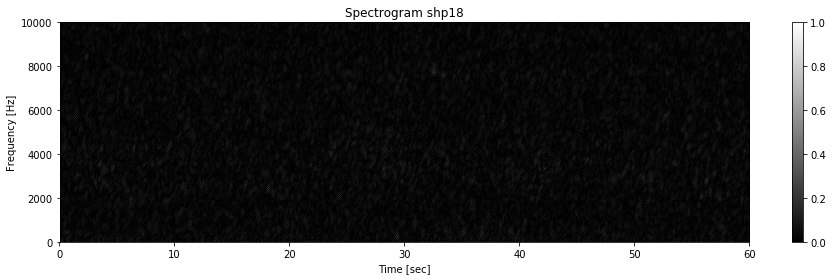

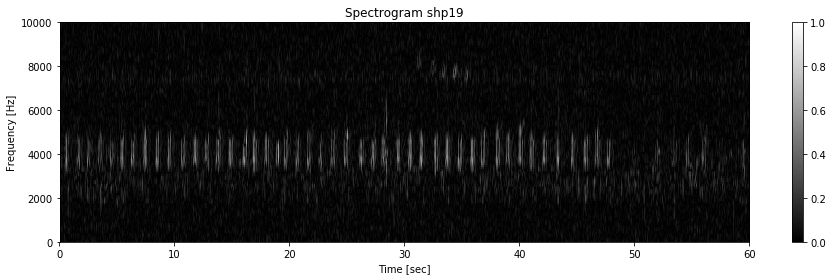

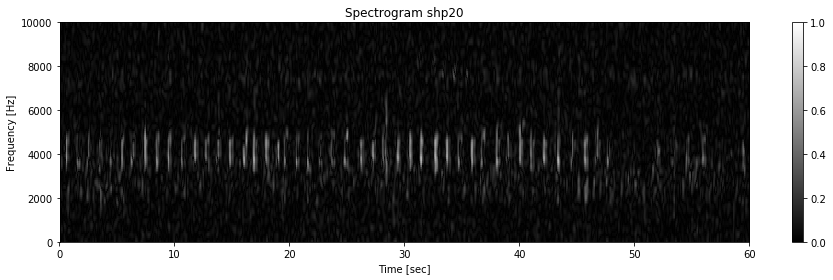

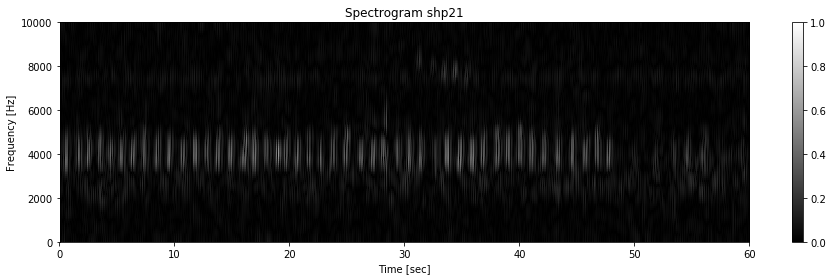

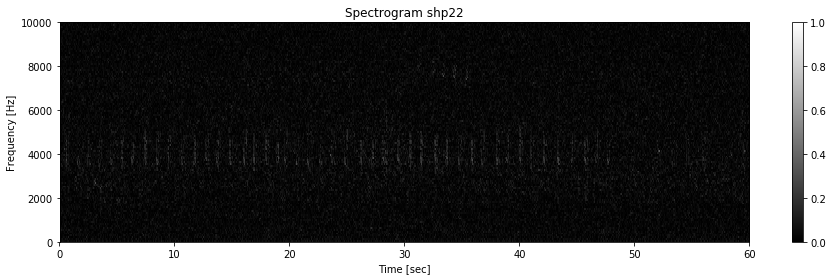

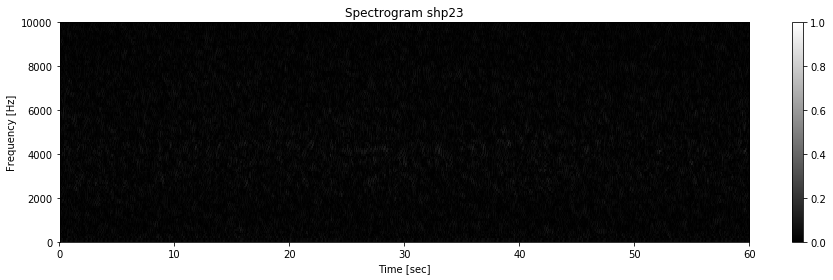

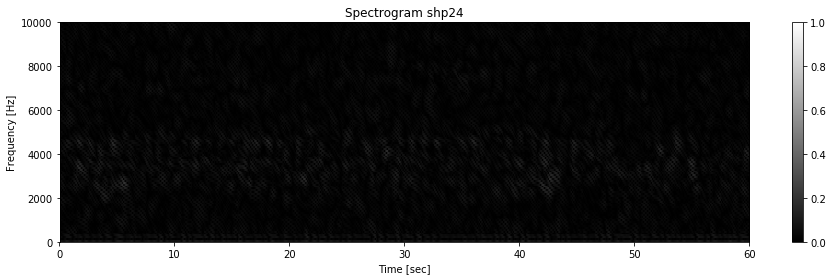

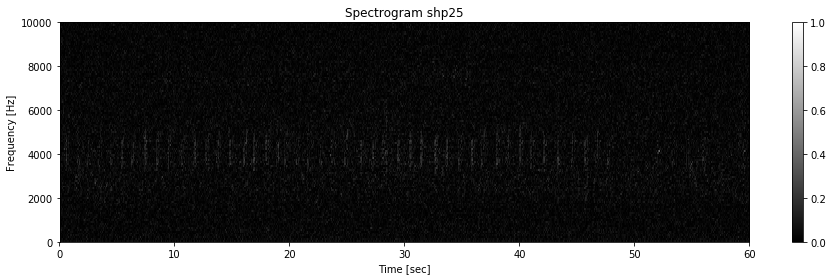

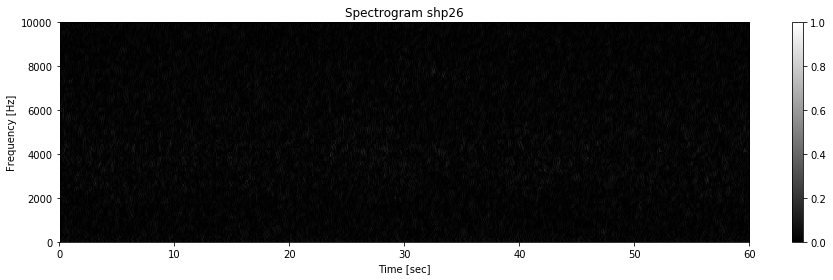

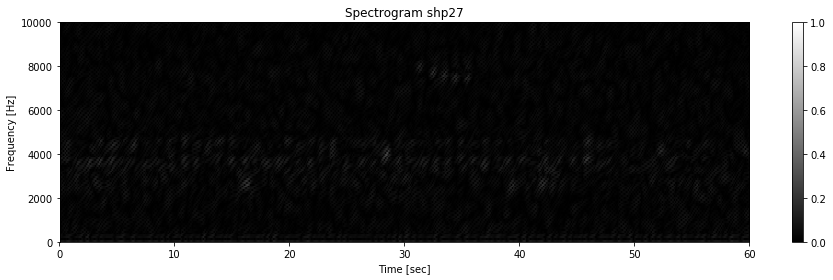

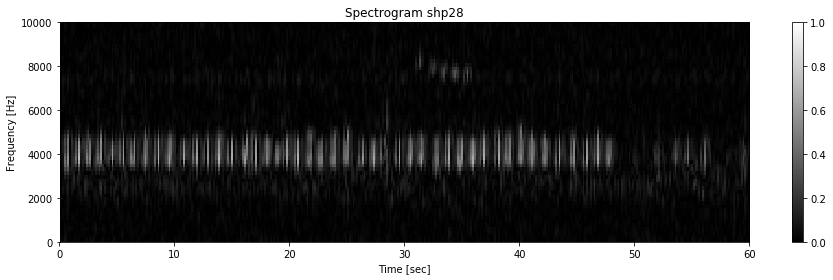

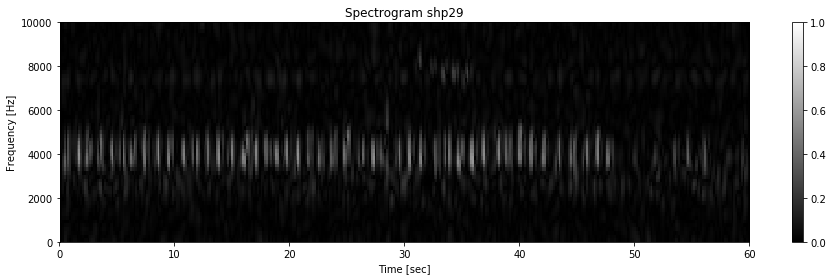

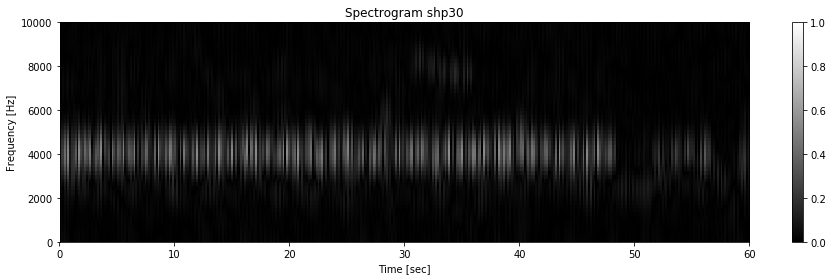

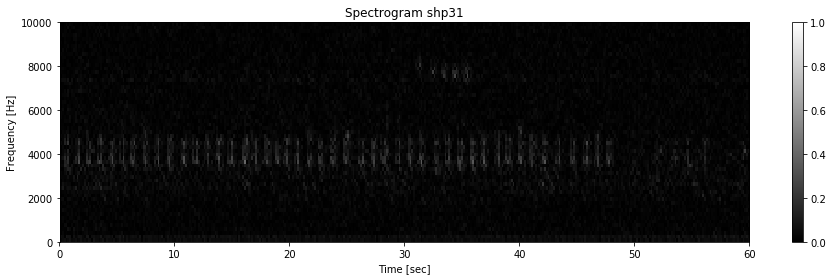

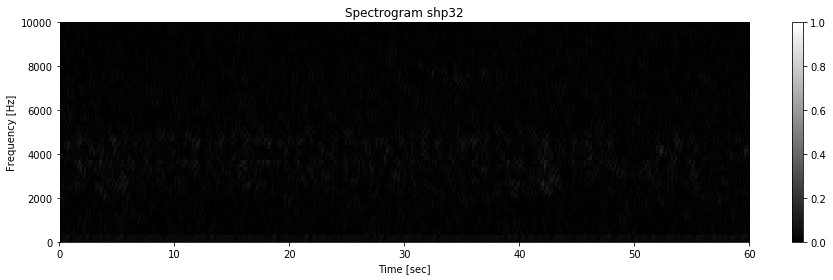

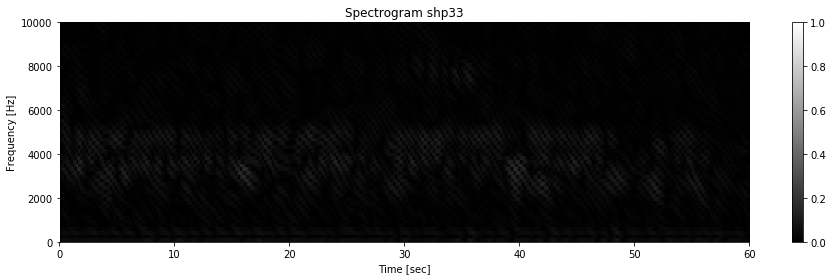

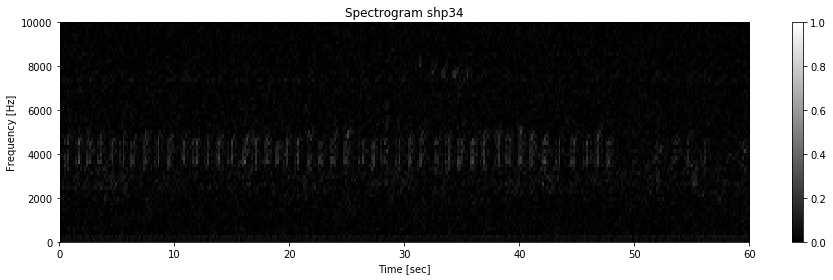

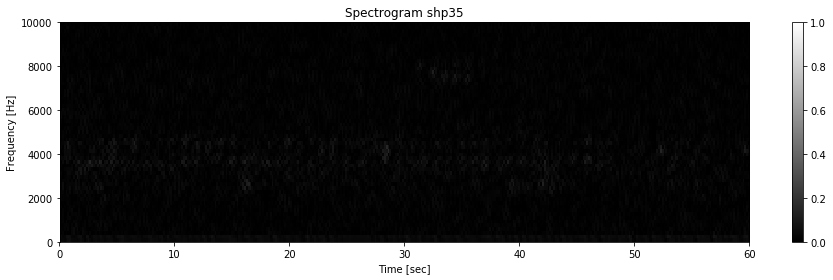

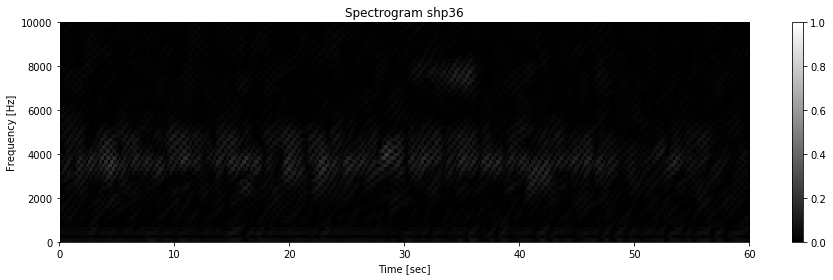

In [12]:
# multiresolution image filtering (Gaussian pyramids)
im_filtlist = maad.features.filter_multires(im_ref, ext, kernels, params, npyr=4,display=True, savefig=None, dpi=48)

Extract shape and centroids features for each ROI corresponding to the result of each wavelet

In [14]:
# Extract shape features for each roi
params_shape, shape_features = maad.features.shapes(im_filtlist = im_filtlist, params = params,  im_rois=im_rois)
# Extract centroids features for each roi
centroid_features = maad.features.centroids(im=im_ref, ext=ext, date=date, im_rois=im_rois)

Save the features in a .csv file

In [20]:
features = maad.features.save_csv(filename[:-4]+'.csv', shape_features, centroid_features, label_features = rois_label)

Rapid vizualization the features with Pandas functions

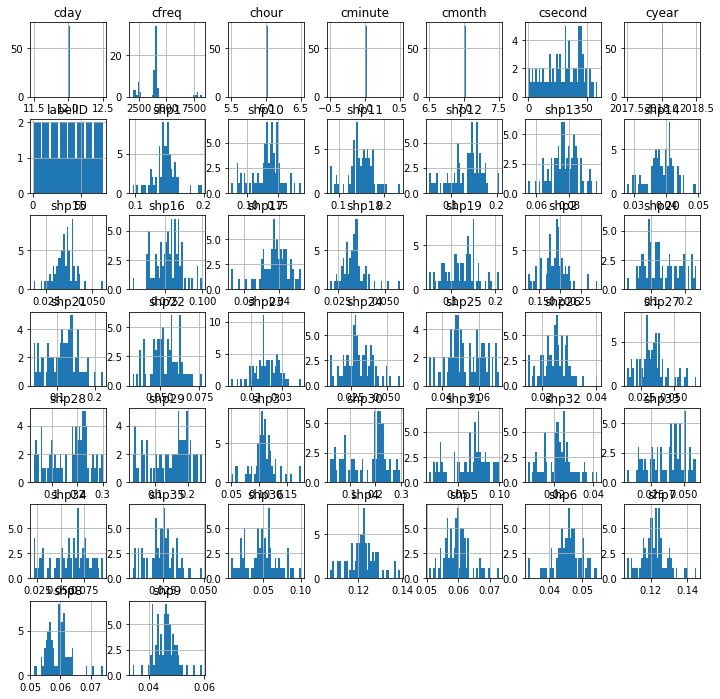

shp1       1.000000
shp2       0.913441
shp3       0.883103
shp7       0.716730
shp4       0.682827
shp10      0.637976
shp12      0.594190
shp11      0.562974
shp20      0.318749
shp25      0.224366
shp16      0.216084
shp5       0.215610
shp19      0.204567
shp30      0.161350
shp13      0.148163
shp8       0.146774
shp29      0.062451
shp21      0.053032
shp28      0.047238
shp22      0.041310
labelID    0.024085
shp9      -0.004199
csecond   -0.011637
shp23     -0.024118
shp34     -0.031786
shp24     -0.055844
shp6      -0.065452
shp14     -0.081593
shp36     -0.090480
shp33     -0.092747
shp31     -0.111400
shp15     -0.115079
shp17     -0.192585
shp32     -0.222786
shp35     -0.294602
shp26     -0.353018
shp27     -0.388186
shp18     -0.456195
cfreq     -0.595884
cyear           NaN
cmonth          NaN
cday            NaN
chour           NaN
cminute         NaN
Name: shp1, dtype: float64

In [21]:
"""****************************************************************************
# ---------------   FEATURES VIZUALIZATION WITH PANDAS   ----------------------
****************************************************************************"""
features = pd.read_csv(filename[:-4]+'.csv')
 
# table with a summray of the features value
features.describe()
 
# histograpm for each features
features.hist(bins=40, figsize=(12,12))
plt.show()
 
# Find correlations. 
corr_matrix = features.corr()
corr_matrix["shp1"].sort_values(ascending=False)

2 examples of classification/clustering of the data.

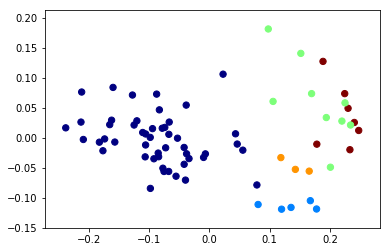

In [23]:
"""****************************************************************************
# ---------------           CLASSIFY FEATURES            ----------------------
****************************************************************************"""

# =============================================================================
# Machine learning :
# Clustering/classication :  PCA
# =============================================================================

from sklearn.decomposition import PCA
import numpy as np

X = []
nshp = len(params_shape)
nrow, ncol = features.shape
select_header = list(features.columns[ncol-nshp:ncol])
#select_header.append('cfreq')
# Get the relevant shapes values
X = features[select_header].values

Y = []
# Create a vector Y with colors corresponding to the label
unique_labelName = np.unique(np.array(features.labelName))
for label in features.labelName:
    for ii, name in enumerate(unique_labelName):   
        if label in name :
            Y.append(int(ii))

# Calcul the PCA and display th results
plt.figure()
pca = PCA(n_components=2)
Xp = pca.fit_transform(X)
plt.scatter(Xp[:, 0], Xp[:, 1], c=Y, s=40, cmap='jet')

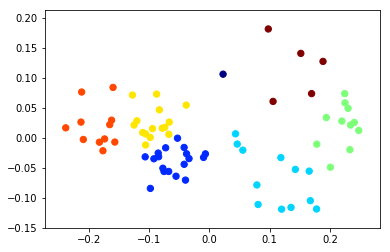

In [24]:
# =============================================================================
# Machine learning :
# Clustering/classication :  Gaussian Mixture Model (GMM)
# =============================================================================
from sklearn import mixture
C = 7 # Number of clusters
clf = mixture.GaussianMixture(n_components=C, covariance_type='full')
clf.fit(X)
yp=clf.predict(X)

plt.figure()
plt.scatter(Xp[:,0],Xp[:,1],c=yp,s=40, cmap='jet')

In [ ]:
"""
# =============================================================================
# Machine learning :
# Clustering/classication :  HDDC (Bouveryon)
# =============================================================================
# Parameters for HDDA
MODEL = 'M2'
C = 5 # Number of clusters
th = 0.05 # The threshold for the Cattel test
# Select the best model using BIC or ICL
bic, icl = [], []
for model_ in ['M1','M2','M3','M4','M5','M6','M7','M8']:
    model = maad.cluster.HDDC(C=C, th=th,model=model_)
    model.fit(X)
    bic.append(model.bic)
    icl.append(model.icl)
    
plt.figure()
plt.plot(bic)
plt.plot(icl)
plt.legend(("BIC", "ICL"))
plt.xticks(np.arange(8), ('M1','M2','M3','M4','M5','M6','M7','M8'))
plt.grid()

model = maad.cluster.HDDC(C=C,th=th,model=MODEL)
model.fit(X)
model.bic
yp=model.predict(X)

plt.figure()
plt.scatter(Xp[:,0],Xp[:,1],c=yp,s=40, cmap='jet')
"""